In [3]:
import os
print(len(image_paths))
print(image_paths[:5])


200
['/content/qr_code_data/Assignment Data/First Print/input_image_bubble.png', '/content/qr_code_data/Assignment Data/First Print/input_image_agenda (4).png', '/content/qr_code_data/Assignment Data/First Print/input_image_canvas.png', '/content/qr_code_data/Assignment Data/First Print/input_image_assume (3).png', '/content/qr_code_data/Assignment Data/First Print/input_image_assume (1).png']


In [4]:
image_paths = glob.glob(os.path.join(extract_path, "**", "*.png"), recursive=True)
print(f"Found {len(image_paths)} images.")


Found 200 images.


In [6]:
valid_indices = labels != -1
print("Labels:", np.unique(labels, return_counts=True))


Labels: (array([], dtype=int64), array([], dtype=int64))


Found 200 images.
Labels distribution: (array([0, 1]), array([100, 100]))
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.5131 - loss: 4.0454 - val_accuracy: 0.4750 - val_loss: 0.6775
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.5937 - loss: 0.6776 - val_accuracy: 0.9000 - val_loss: 0.5032
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.6578 - loss: 0.5998 - val_accuracy: 0.8750 - val_loss: 0.3856
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.8172 - loss: 0.4087 - val_accuracy: 0.9500 - val_loss: 0.2414
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9057 - loss: 0.2511 - val_accuracy: 0.9750 - val_loss: 0.1382
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8866 - loss: 0.2528 - val_accuracy: 0.9750 - val_loss: 0.1400
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9746 - loss: 0.1248 - val_accuracy: 0.9500 - val_loss: 0.0739
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9789 - loss: 0.0583 - val_accuracy: 1.0000 - val_loss: 0

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step


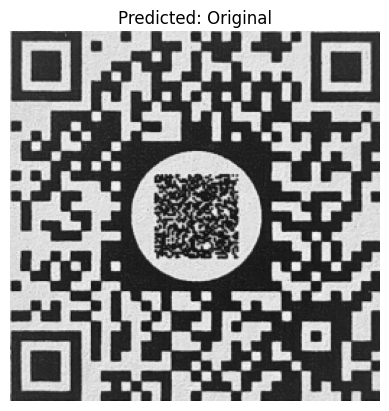

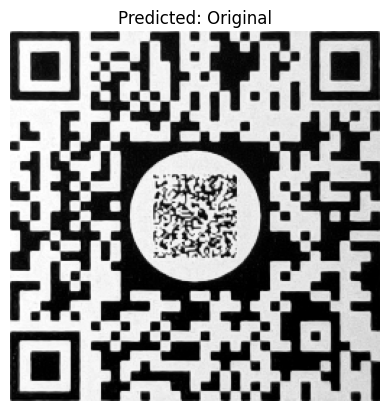

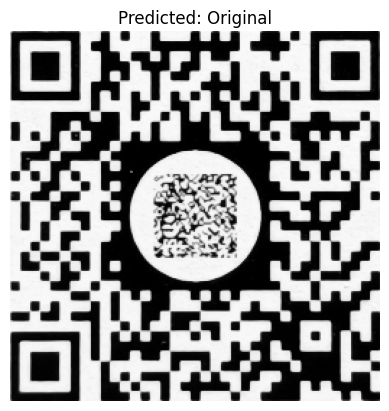

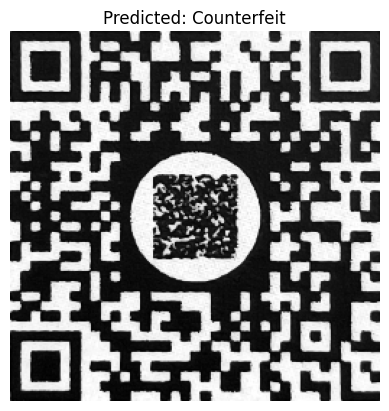

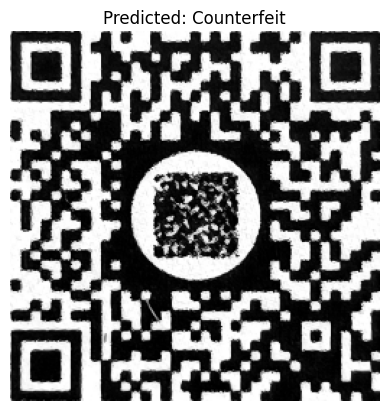

CNN model saved to /content/cnn_model.h5
Final CNN Accuracy: 1.0000


In [11]:
import zipfile
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


zip_path = "/content/Assignment_Data.zip"
extract_path = "/content/qr_code_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

image_paths = glob.glob(os.path.join(extract_path, "**", "*.png"), recursive=True)

print(f"Found {len(image_paths)} images.")

if len(image_paths) == 0:
    raise ValueError("No images found. Check the dataset extraction path.")

labels = []
for img in image_paths:
    if "First Print" in img:
        labels.append(0)
    elif "Second Print" in img:
        labels.append(1)
    else:
        print("Unknown category:", img)
        labels.append(-1)

labels = np.array(labels)

valid_indices = labels != -1
image_paths = np.array(image_paths)[valid_indices]
labels = labels[valid_indices]

print("Labels distribution:", np.unique(labels, return_counts=True))


def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    return img

preprocessed_images = np.array([preprocess_image(img) for img in image_paths])


labels_cnn = to_categorical(labels, num_classes=2)

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    preprocessed_images.reshape(-1, 256, 256, 1), labels_cnn, test_size=0.2, random_state=42
)


def build_cnn(input_shape=(256, 256, 1)):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn()
cnn_model.fit(X_train_cnn, y_train_cnn, epochs=20, batch_size=16, validation_data=(X_test_cnn, y_test_cnn))
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_cnn, y_test_cnn)
print("CNN Accuracy:", cnn_acc)


predictions = cnn_model.predict(X_test_cnn)
predicted_classes = np.argmax(predictions, axis=1)

for i in range(5):
    plt.imshow(X_test_cnn[i].reshape(256, 256), cmap='gray')
    plt.title(f"Predicted: {'Original' if predicted_classes[i] == 0 else 'Counterfeit'}")
    plt.axis('off')
    plt.show()


cnn_model_path = "/content/cnn_model.h5"
cnn_model.save(cnn_model_path)
print(f"CNN model saved to {cnn_model_path}")


print(f"Final CNN Accuracy: {cnn_acc:.4f}")


In [14]:
import os
import cv2
import numpy as np
import glob
import joblib
import zipfile
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

zip_path = "/content/Assignment_Data.zip"
extract_path = "/content/qr_code_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

image_paths = glob.glob(os.path.join(extract_path, "**", "*.png"), recursive=True)
print(f"Total images found: {len(image_paths)}")

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    return img / 255.0

def extract_features(img):
    features, _ = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    return features

features = np.array([extract_features(preprocess_image(img)) for img in image_paths])
labels = np.array([0 if "First Print" in img else 1 for img in image_paths])

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_svm = grid_search.best_estimator_
best_svm.fit(X_train, y_train)

y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"SVM Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

joblib.dump(best_svm, "/content/svm_model.pkl")
print("SVM model saved successfully!")


Total images found: 200
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
SVM Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

SVM model saved successfully!
